/pfs/data5/home/kit/stud/updzl


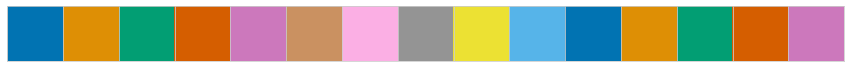

In [1]:

# built-in
import os
import importlib
import math
import datetime

###
# addtional packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

# import pytorch
import torch
from torch import nn, optim
import torch.nn.functional as F
import torch.utils.data as data_utils

from torch.utils.data import Dataset
from torch.utils.data import DataLoader

# set torch seed
torch.manual_seed(42)

# import from sklearn
from sklearn.preprocessing import MinMaxScaler, StandardScaler, MaxAbsScaler, RobustScaler

from matplotlib.offsetbox import AnchoredText
###
# set plot style seaborn
sns.set_style("whitegrid")

# set colors
current_palette = sns.color_palette("colorblind", 15)
sns.palplot(current_palette)
# set workspcae
os.chdir('./')
print(os.getcwd())
font = {#'family' : #'normal',
        'weight' : 'normal',
        'size'   : 12}

plt.rc('font', **font)
def get_nse(y_test, predictions):
  assert len(y_test) == len(predictions)  
  numerator = sum([(y_test[i]-predictions[i])**2 for i in range(len(y_test))])
  y_test_avg = sum(y_test)/len(y_test)
  denominator = sum([(y_test[i]-y_test_avg)**2 for i in range(len(y_test))])
  NSE = 1- (numerator/denominator)
  return NSE

def kge(simulations, evaluation):
    """Original Kling-Gupta Efficiency (KGE) and its three components
    (r, α, β) as per `Gupta et al., 2009
    <https://doi.org/10.1016/j.jhydrol.2009.08.003>`_.
    Note, all four values KGE, r, α, β are returned, in this order.
    :Calculation Details:
        .. math::
           E_{\\text{KGE}} = 1 - \\sqrt{[r - 1]^2 + [\\alpha - 1]^2
           + [\\beta - 1]^2}
        .. math::
           r = \\frac{\\text{cov}(e, s)}{\\sigma({e}) \\cdot \\sigma(s)}
        .. math::
           \\alpha = \\frac{\\sigma(s)}{\\sigma(e)}
        .. math::
           \\beta = \\frac{\\mu(s)}{\\mu(e)}
        where *e* is the *evaluation* series, *s* is (one of) the
        *simulations* series, *cov* is the covariance, *σ* is the
        standard deviation, and *μ* is the arithmetic mean.
    """
    # calculate error in timing and dynamics r
    # (Pearson's correlation coefficient)
    sim_mean = np.mean(simulations, axis=0, dtype=np.float64)
    obs_mean = np.mean(evaluation, dtype=np.float64)

    r_num = np.sum((simulations - sim_mean) * (evaluation - obs_mean),
                   axis=0, dtype=np.float64)
    r_den = np.sqrt(np.sum((simulations - sim_mean) ** 2,
                           axis=0, dtype=np.float64)
                    * np.sum((evaluation - obs_mean) ** 2,
                             dtype=np.float64))
    r = r_num / r_den
    # calculate error in spread of flow alpha
    alpha = np.std(simulations, axis=0) / np.std(evaluation, dtype=np.float64)
    # calculate error in volume beta (bias of mean discharge)
    beta = (np.sum(simulations, axis=0, dtype=np.float64)
            / np.sum(evaluation, dtype=np.float64))
    # calculate the Kling-Gupta Efficiency KGE
    kge_ = 1 - np.sqrt((r - 1) ** 2 + (alpha - 1) ** 2 + (beta - 1) ** 2)

    return np.vstack((kge_, r, alpha, beta))

In [2]:

os.chdir('/pfs/data5/home/kit/stud/updzl/LR_check/testscreen')
test_1 = pd.read_csv('20220630-134455_Schwebich_testNSE_B', header=None)
train_1 = pd.read_csv('20220630-134455_Schwebich_trainloss_B', header=None)
os.chdir('/pfs/data5/home/kit/stud/updzl/LR_check/testscreen_copy2')
test_2 = pd.read_csv('20220630-134418_Schwebich_testNSE_B', header=None)
train_2 = pd.read_csv('20220630-134418_Schwebich_trainloss_B', header=None)

Text(0.5, 0, 'Epoch')

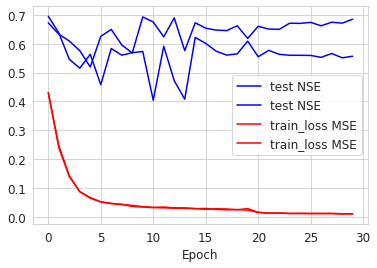

In [3]:
plt.plot(test_1, 'b')
plt.plot(test_2, 'b')
plt.plot(train_1, 'r')
plt.plot(train_2, 'r')
plt.legend(['test NSE', 'test NSE', 'train_loss MSE', 'train_loss MSE'])
plt.xlabel('Epoch')

(14153.0, 14517.0)

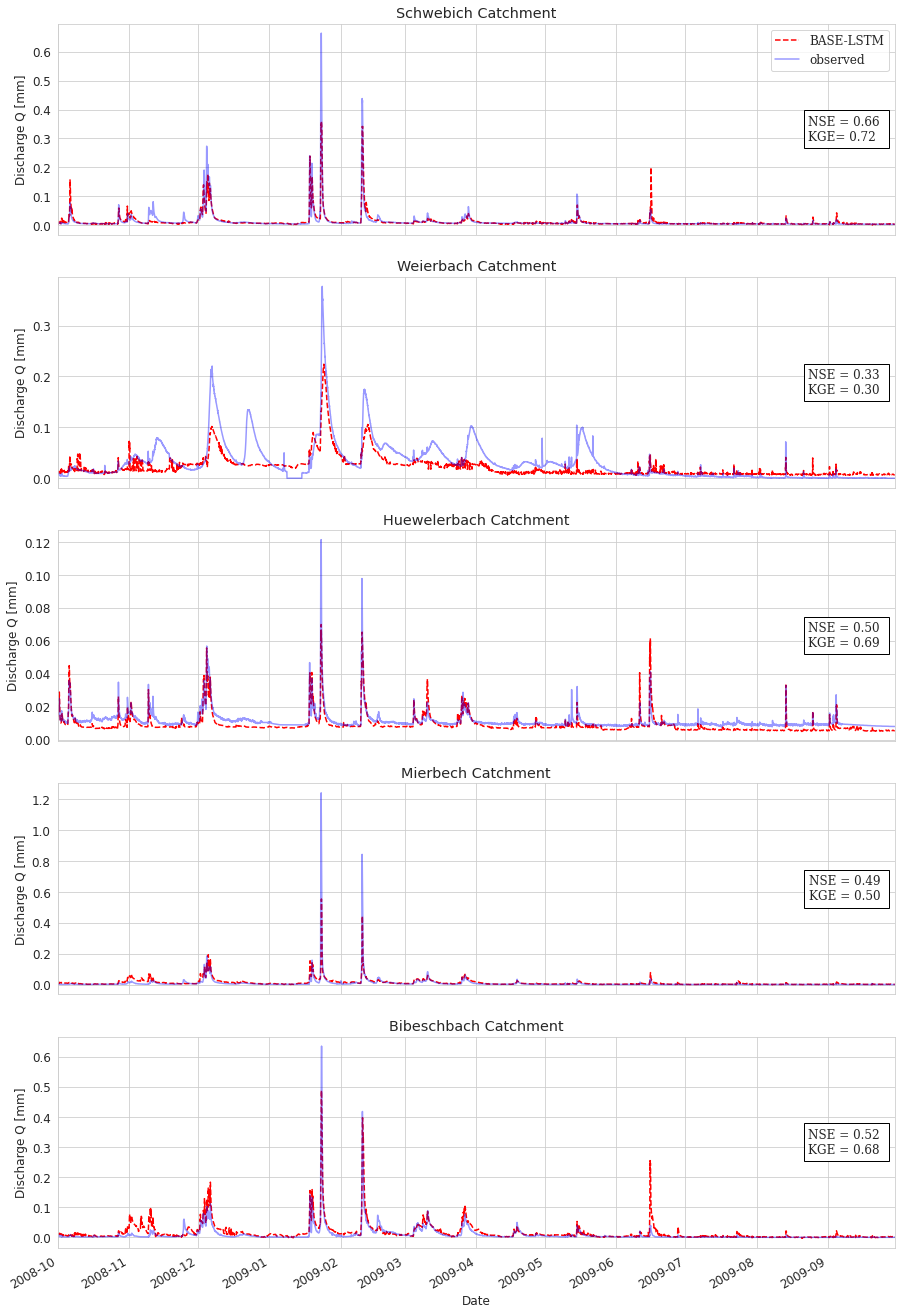

In [4]:
#### PLOT for Experiment 1.1 results BASE LSTM
### stacked plot sim vs obs 1 year
import matplotlib.dates as mdates

os.chdir('/pfs/data5/home/kit/stud/updzl/Experiment 1/Best_Performances/')

Schwebich_Base = pd.read_csv('Schwebich/results_best_model_Schwebich_Experiment_B', index_col='Date', parse_dates=['Date'])
Schwebich_All = pd.read_csv('Schwebich/results_best_model_Schwebich_Experiment_C', index_col='Date', parse_dates=['Date'])
Schwebich_Selec = pd.read_csv('Schwebich/results_best_model_Schwebich_Experiment_A', index_col='Date', parse_dates=['Date'])
Schwebich_Selec_train = pd.read_csv('Schwebich/results_train_best_model_Schwebich_Experiment_A', index_col='Date', parse_dates=['Date'])

Weierbach_Base = pd.read_csv('Weierbach/results_best_model_Weierbach_Experiment_B', index_col='Date', parse_dates=['Date'])
Weierbach_All = pd.read_csv('Weierbach/results_best_model_Weierbach_Experiment_C', index_col='Date', parse_dates=['Date'])
Weierbach_Selec = pd.read_csv('Weierbach/results_best_model_Weierbach_Experiment_A', index_col='Date', parse_dates=['Date'])
Weierbach_Selec_train = pd.read_csv('Weierbach/results_train_best_model_Weierbach_Experiment_A', index_col='Date', parse_dates=['Date'])

Huewelerbach_Base = pd.read_csv('Huewelerbach/results_best_model_Huewelerbach_Experiment_B', index_col='Date', parse_dates=['Date'])
Huewelerbach_All = pd.read_csv('Huewelerbach/results_best_model_Huewelerbach_Experiment_C', index_col='Date', parse_dates=['Date'])
Huewelerbach_Selec = pd.read_csv('Huewelerbach/results_best_model_Huewelerbach_Experiment_A', index_col='Date', parse_dates=['Date'])
Huewelerbach_Selec_train = pd.read_csv('Huewelerbach/results_train_best_model_Huewelerbach_Experiment_A', index_col='Date', parse_dates=['Date'])

Mierbech_Base = pd.read_csv('Mierbech/results_best_model_Mierbech_Experiment_B', index_col='Date', parse_dates=['Date'])
Mierbech_All = pd.read_csv('Mierbech/results_best_model_Mierbech_Experiment_C', index_col='Date', parse_dates=['Date'])
Mierbech_Selec = pd.read_csv('Mierbech/results_best_model_Mierbech_Experiment_A', index_col='Date', parse_dates=['Date'])
Mierbech_Selec_train = pd.read_csv('Mierbech/results_train_best_model_Mierbech_Experiment_A', index_col='Date', parse_dates=['Date'])

Bibeschbach_Base = pd.read_csv('Bibeschbach/results_best_model_Bibeschbach_Experiment_B', index_col='Date', parse_dates=['Date'])
Bibeschbach_All = pd.read_csv('Bibeschbach/results_best_model_Bibeschbach_Experiment_C', index_col='Date', parse_dates=['Date'])
Bibeschbach_Selec = pd.read_csv('Bibeschbach/results_best_model_Bibeschbach_Experiment_A', index_col='Date', parse_dates=['Date'])
Bibeschbach_Selec_train = pd.read_csv('Bibeschbach/results_train_best_model_Bibeschbach_Experiment_A', index_col='Date', parse_dates=['Date'])

##
start = '2008-10-01 00:00:00'
end = '2009-09-30 23:00:00'

fig, axs = plt.subplots(5, sharex=True)
import matplotlib.font_manager
plt.rcParams['font.family'] = 'DeJavu Serif'
plt.rcParams['font.serif'] = ['Times New Roman']
fig.set_figheight(25)
fig.set_figwidth(15)
fig.autofmt_xdate()
axs[0].plot(Schwebich_Base[start:end].index, Schwebich_Base.loc[start:end, 'Q_sim'], 'r--')
axs[0].plot(Schwebich_Base[start:end].index, Schwebich_Base.loc[start:end, 'Q_obs'], 'b', alpha=0.4)
axs[0].add_artist(AnchoredText('NSE = 0.66 \nKGE= 0.72 ', loc=7))
axs[0].set_title('Schwebich Catchment')
axs[0].legend(['BASE-LSTM', 'observed'])
axs[0].set_ylabel('Discharge Q [mm]')
axs[1].plot(Weierbach_Base[start:end].index, Weierbach_Base.loc[start:end, 'Q_sim'], 'r--')
axs[1].plot(Weierbach_Base[start:end].index, Weierbach_Base.loc[start:end, 'Q_obs'], 'b', alpha=0.4)
axs[1].add_artist(AnchoredText('NSE = 0.33 \nKGE = 0.30 ', loc=7))
axs[1].set_title('Weierbach Catchment')
axs[1].set_ylabel('Discharge Q [mm]')
axs[2].plot(Huewelerbach_Base[start:end].index, Huewelerbach_Base.loc[start:end, 'Q_sim'], 'r--')
axs[2].plot(Huewelerbach_Base[start:end].index, Huewelerbach_Base.loc[start:end, 'Q_obs'], 'b', alpha=0.4)
axs[2].add_artist(AnchoredText('NSE = 0.50 \nKGE = 0.69 ', loc=7))
axs[2].set_title('Huewelerbach Catchment')
axs[2].set_ylabel('Discharge Q [mm]')
axs[3].plot(Mierbech_Base[start:end].index, Mierbech_Base.loc[start:end, 'Q_sim'], 'r--')
axs[3].plot(Mierbech_Base[start:end].index, Mierbech_Base.loc[start:end, 'Q_obs'], 'b', alpha=0.4)
axs[3].add_artist(AnchoredText('NSE = 0.49 \nKGE = 0.50 ', loc=7))
axs[3].set_title('Mierbech Catchment')
axs[3].set_ylabel('Discharge Q [mm]')
axs[4].plot(Bibeschbach_Base[start:end].index, Bibeschbach_Base.loc[start:end, 'Q_sim'], 'r--')
axs[4].plot(Bibeschbach_Base[start:end].index, Bibeschbach_Base.loc[start:end, 'Q_obs'], 'b', alpha=0.4)
axs[4].add_artist(AnchoredText('NSE = 0.52 \nKGE = 0.68', loc=7))
axs[4].set_title('Bibeschbach Catchment')
axs[4].set_xlabel('Date')
axs[4].set_ylabel('Discharge Q [mm]')

axs[4].set_xlim(datetime.date(2008, 10, 1), datetime.date(2009, 9, 30))
#fig.autofmt_xdate()
#axs[4].xaxis.set_major_locator(mdates.MonthLocator(interval=1))
#axs[4].xaxis.set_major_formatter(mdates.DateFormatter('%d-%m-%Y'))

In [5]:
catch = Bibeschbach_Base
catch2 = Bibeschbach_All
catch3 = Bibeschbach_Selec
catch_str = 'Huewelerbach'
KGE = kge(catch3['Q_sim'].to_numpy(), catch3['Q_obs'].to_numpy())
NSE = get_nse(catch3['Q_obs'].to_numpy(),catch3['Q_sim'].to_numpy()) 
print(KGE)
print(NSE)

sum(n < 0 for n in catch.values.flatten())
print(catch)

[[0.7471732 ]
 [0.85141354]
 [0.85149029]
 [0.85932903]]
0.7204153448551156
                        Q_sim     Q_obs
Date                                   
2004-10-11 16:00:00  0.004393  0.007692
2004-10-11 16:30:00  0.004393  0.007692
2004-10-11 17:00:00  0.004410  0.007692
2004-10-11 17:30:00  0.004416  0.007981
2004-10-11 18:00:00  0.004408  0.007981
...                       ...       ...
2010-09-29 22:00:00  0.005584  0.001189
2010-09-29 22:30:00  0.005517  0.001155
2010-09-29 23:00:00  0.005381  0.001155
2010-09-29 23:30:00  0.005148  0.001121
2010-09-30 00:00:00  0.002727  0.001070

[104597 rows x 2 columns]


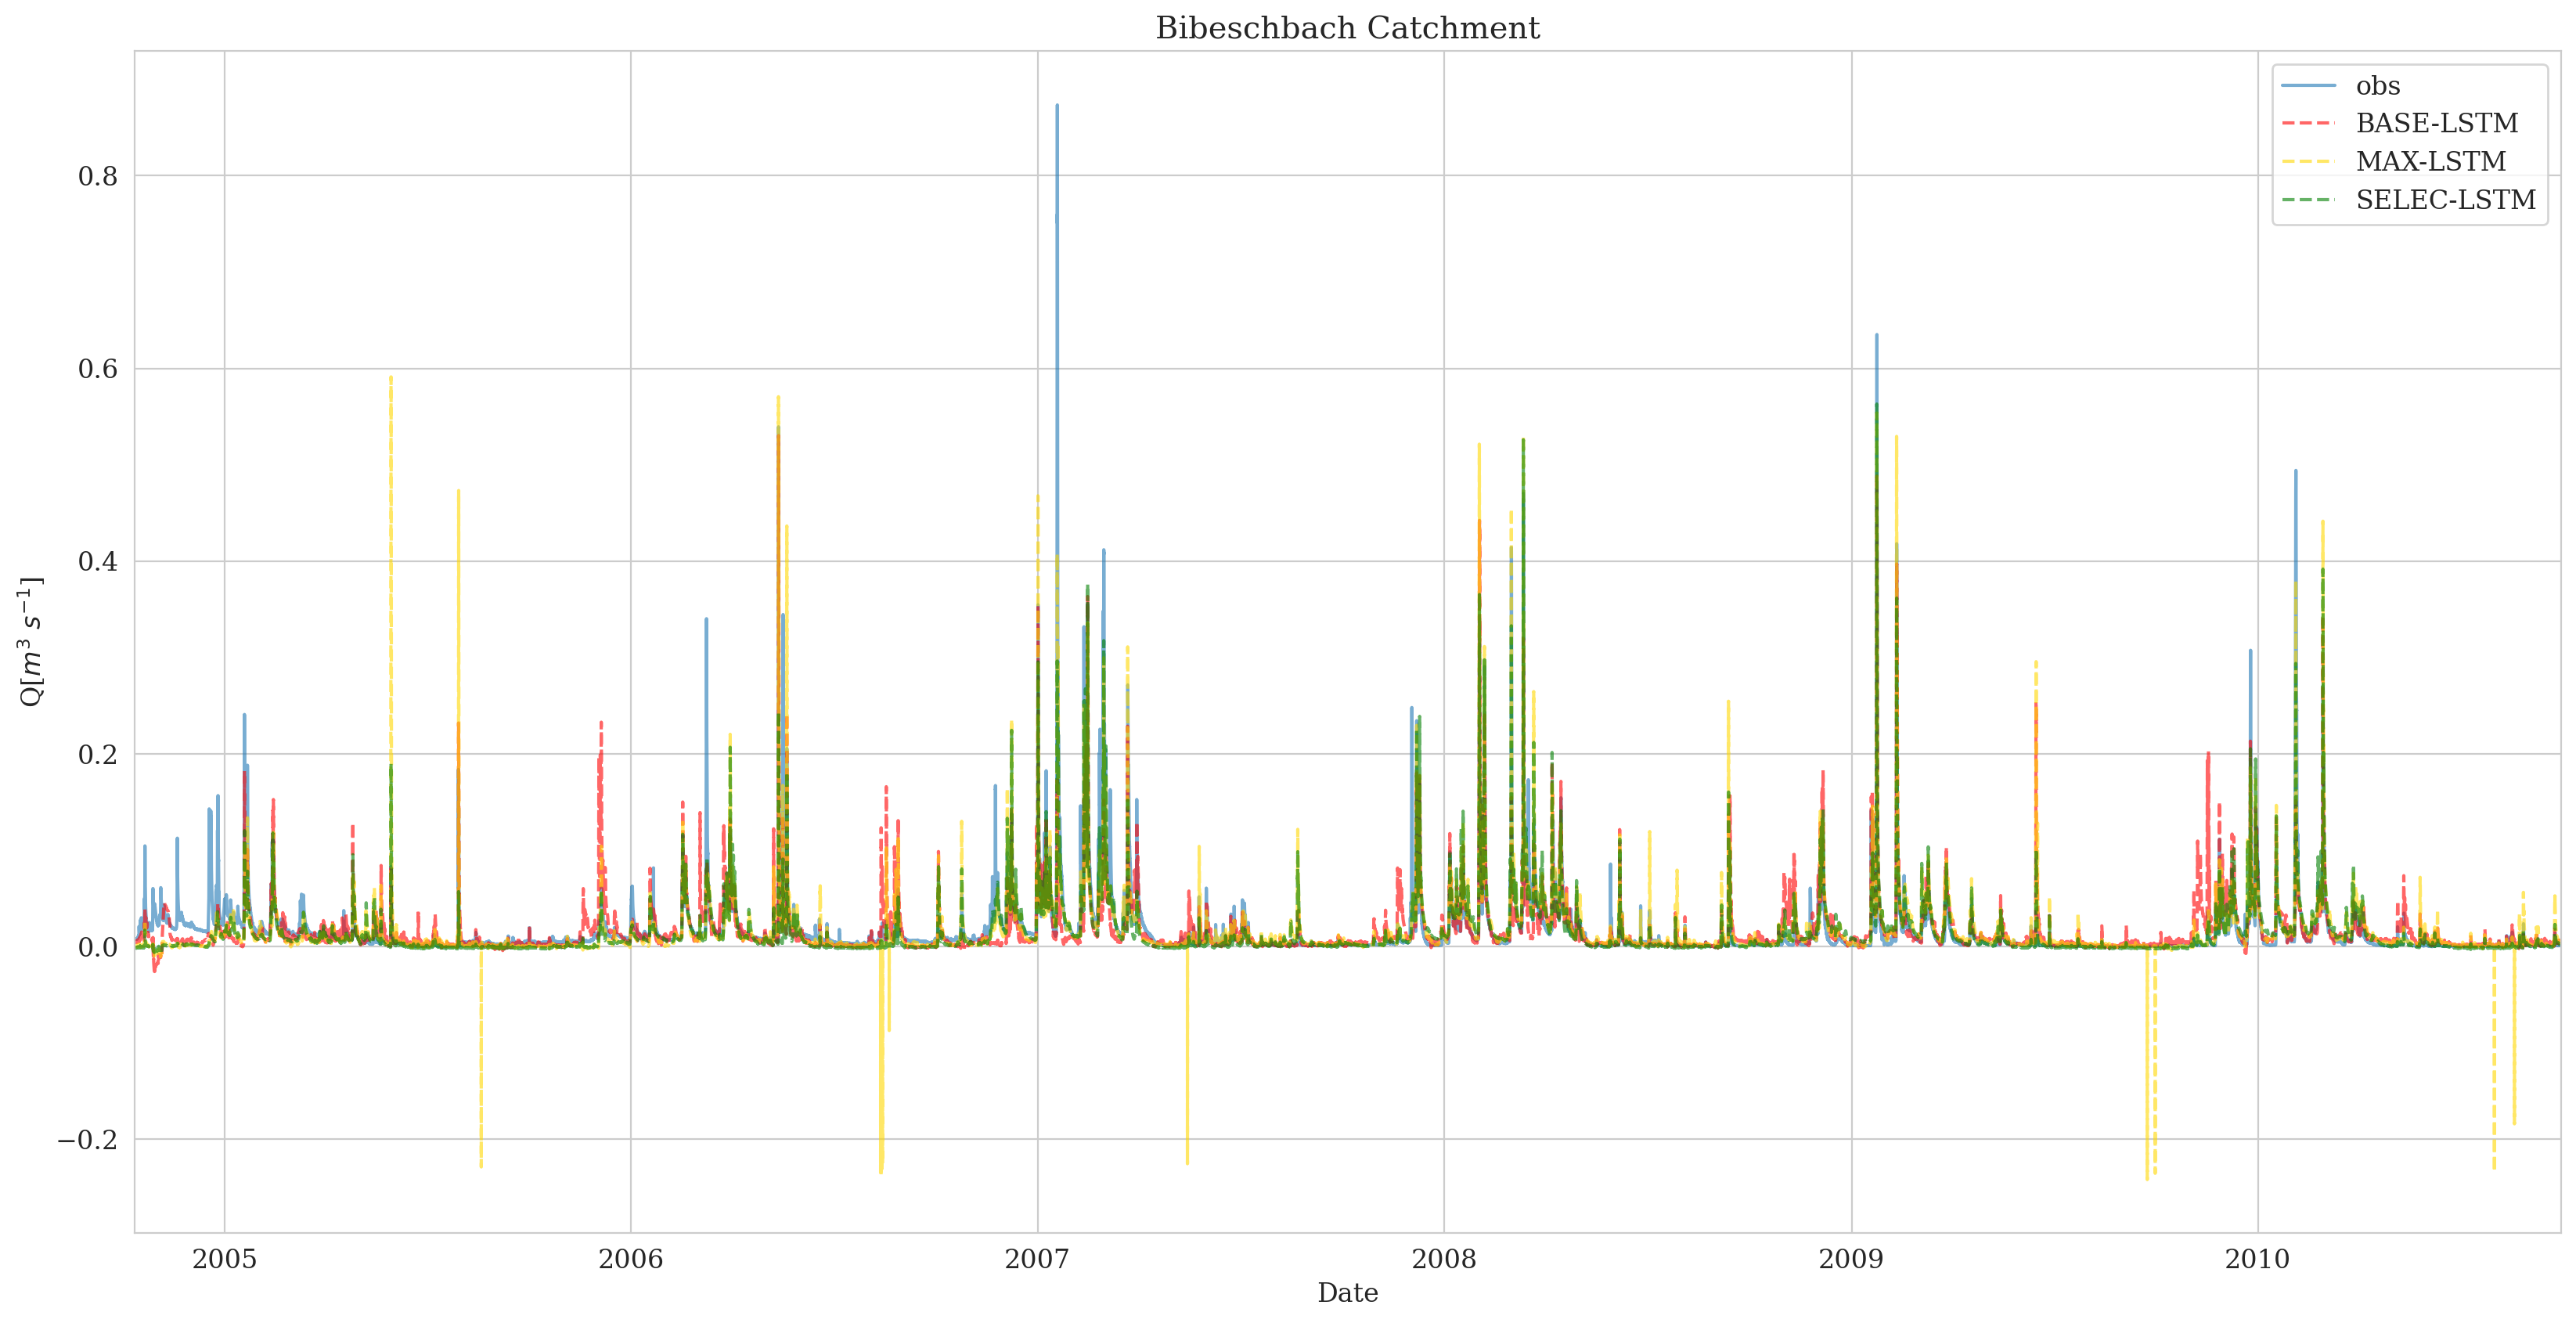

In [6]:
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt
figure(figsize=(20, 10), dpi=200)
plt.plot(catch.index, catch['Q_obs'],   alpha=0.6)
plt.plot(catch.index, catch['Q_sim'], '--', color='r', alpha= 0.6)
plt.plot(catch.index, catch2['Q_sim'], '--', color='gold', alpha= 0.6)
plt.plot(catch.index, catch3['Q_sim'], '--', color='g', alpha= 0.6)
plt.legend(['obs', 'BASE-LSTM', 'MAX-LSTM', 'SELEC-LSTM'])
plt.xlabel('Date')
plt.ylabel('Q[$m^3$ $s^{-1}$]')
plt.xlim(min(catch.index) , max(catch.index))
plt.title('Bibeschbach Catchment')
os.chdir('/pfs/data5/home/kit/stud/updzl/Plots/evaluation period/')
plt.savefig(catch_str+'_comparision_hydrogrpah.png', bbox_inches='tight', pad_inches = 0)

(14153.0, 14517.0)

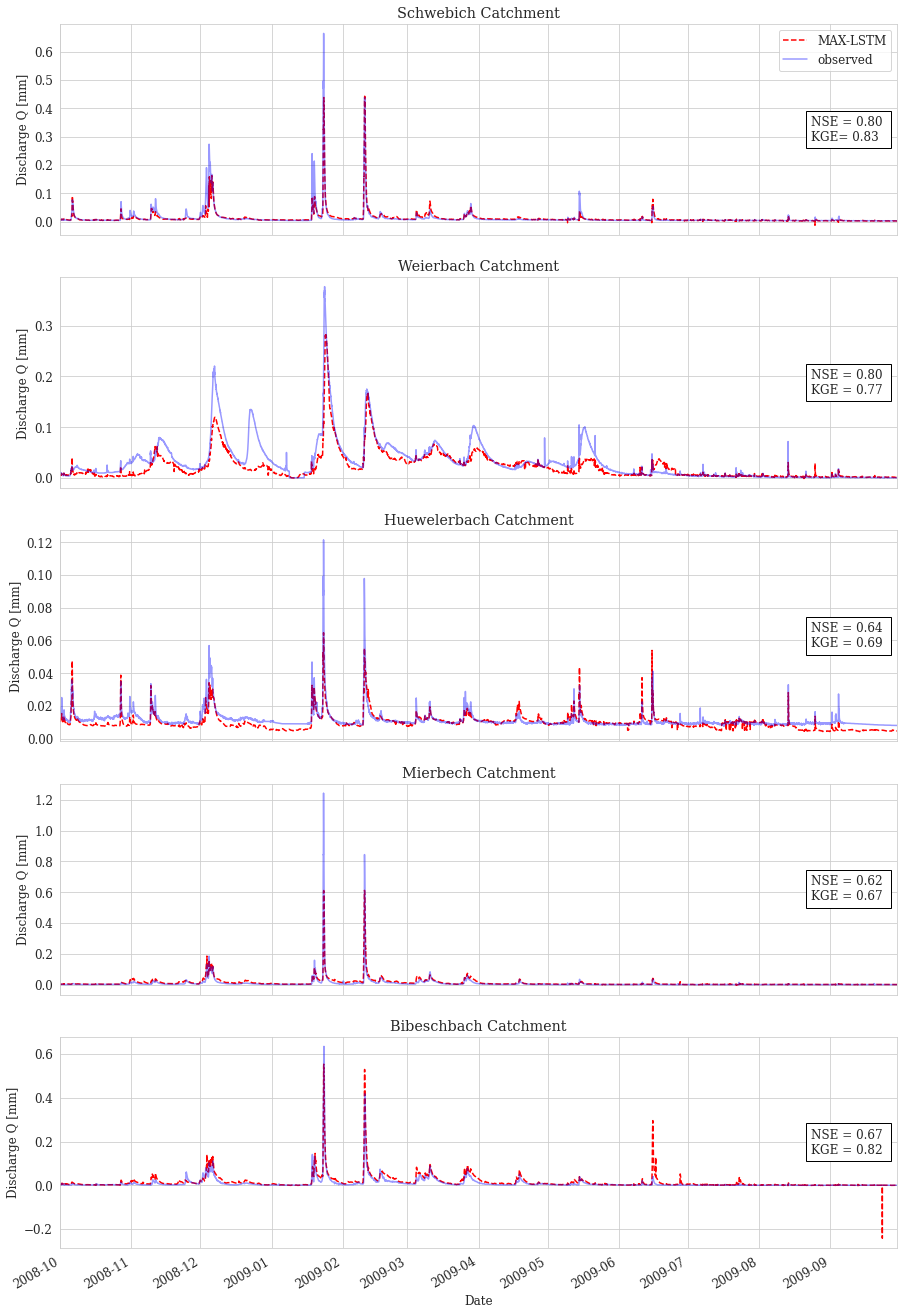

In [7]:
fig, axs = plt.subplots(5, sharex=True)
plt.rcParams['font.family'] = 'DeJavu Serif'
plt.rcParams['font.serif'] = ['Times New Roman']
fig.set_figheight(25)
fig.set_figwidth(15)
fig.autofmt_xdate()
axs[0].plot(Schwebich_All[start:end].index, Schwebich_All.loc[start:end, 'Q_sim'], 'r--')
axs[0].plot(Schwebich_All[start:end].index, Schwebich_All.loc[start:end, 'Q_obs'], 'b', alpha=0.4)
axs[0].add_artist(AnchoredText('NSE = 0.80 \nKGE= 0.83 ', loc=7))
axs[0].set_title('Schwebich Catchment')
axs[0].legend(['MAX-LSTM', 'observed'])
axs[0].set_ylabel('Discharge Q [mm]')
axs[1].plot(Weierbach_All[start:end].index, Weierbach_All.loc[start:end, 'Q_sim'], 'r--')
axs[1].plot(Weierbach_All[start:end].index, Weierbach_All.loc[start:end, 'Q_obs'], 'b', alpha=0.4)
axs[1].add_artist(AnchoredText('NSE = 0.80 \nKGE = 0.77 ', loc=7))
axs[1].set_title('Weierbach Catchment')
axs[1].set_ylabel('Discharge Q [mm]')
axs[2].plot(Huewelerbach_All[start:end].index, Huewelerbach_All.loc[start:end, 'Q_sim'], 'r--')
axs[2].plot(Huewelerbach_All[start:end].index, Huewelerbach_All.loc[start:end, 'Q_obs'], 'b', alpha=0.4)
axs[2].add_artist(AnchoredText('NSE = 0.64 \nKGE = 0.69 ', loc=7))
axs[2].set_title('Huewelerbach Catchment')
axs[2].set_ylabel('Discharge Q [mm]')
axs[3].plot(Mierbech_All[start:end].index, Mierbech_All.loc[start:end, 'Q_sim'], 'r--')
axs[3].plot(Mierbech_All[start:end].index, Mierbech_All.loc[start:end, 'Q_obs'], 'b', alpha=0.4)
axs[3].add_artist(AnchoredText('NSE = 0.62 \nKGE = 0.67 ', loc=7))
axs[3].set_title('Mierbech Catchment')
axs[3].set_ylabel('Discharge Q [mm]')
axs[4].plot(Bibeschbach_All[start:end].index, Bibeschbach_All.loc[start:end, 'Q_sim'], 'r--')
axs[4].plot(Bibeschbach_All[start:end].index, Bibeschbach_All.loc[start:end, 'Q_obs'], 'b', alpha=0.4)
axs[4].add_artist(AnchoredText('NSE = 0.67 \nKGE = 0.82', loc=7))
axs[4].set_title('Bibeschbach Catchment')
axs[4].set_ylabel('Discharge Q [mm]')
axs[4].set_xlabel('Date')

axs[4].set_xlim(datetime.date(2008, 10, 1), datetime.date(2009, 9, 30))

(14153.0, 14517.0)

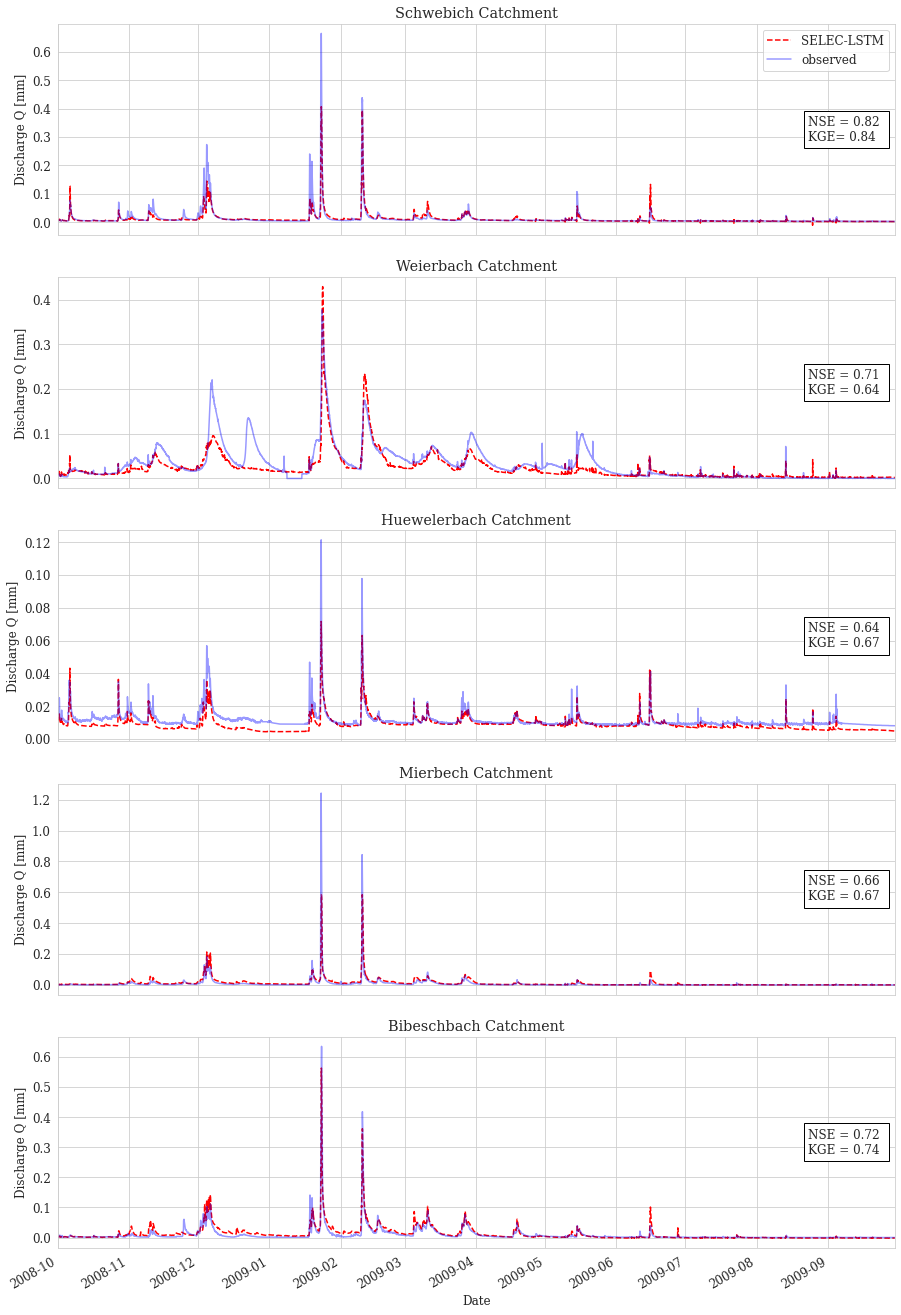

In [8]:
fig, axs = plt.subplots(5, sharex=True)
plt.rcParams['font.family'] = 'DeJavu Serif'
plt.rcParams['font.serif'] = ['Times New Roman']
fig.set_figheight(25)
fig.set_figwidth(15)
fig.autofmt_xdate()
axs[0].plot(Schwebich_Selec[start:end].index, Schwebich_Selec.loc[start:end, 'Q_sim'], 'r--')
axs[0].plot(Schwebich_Selec[start:end].index, Schwebich_Selec.loc[start:end, 'Q_obs'], 'b', alpha=0.4)
axs[0].add_artist(AnchoredText('NSE = 0.82 \nKGE= 0.84 ', loc=7))
axs[0].set_title('Schwebich Catchment')
axs[0].legend(['SELEC-LSTM', 'observed'])
axs[0].set_ylabel('Discharge Q [mm]')
axs[1].plot(Weierbach_Selec[start:end].index, Weierbach_Selec.loc[start:end, 'Q_sim'], 'r--')
axs[1].plot(Weierbach_Selec[start:end].index, Weierbach_Selec.loc[start:end, 'Q_obs'], 'b', alpha=0.4)
axs[1].add_artist(AnchoredText('NSE = 0.71 \nKGE = 0.64 ', loc=7))
axs[1].set_title('Weierbach Catchment')
axs[1].set_ylabel('Discharge Q [mm]')
axs[2].plot(Huewelerbach_Selec[start:end].index, Huewelerbach_Selec.loc[start:end, 'Q_sim'], 'r--')
axs[2].plot(Huewelerbach_Selec[start:end].index, Huewelerbach_Selec.loc[start:end, 'Q_obs'], 'b', alpha=0.4)
axs[2].add_artist(AnchoredText('NSE = 0.64 \nKGE = 0.67 ', loc=7))
axs[2].set_title('Huewelerbach Catchment')
axs[2].set_ylabel('Discharge Q [mm]')
axs[3].plot(Mierbech_Selec[start:end].index, Mierbech_Selec.loc[start:end, 'Q_sim'], 'r--')
axs[3].plot(Mierbech_Selec[start:end].index, Mierbech_Selec.loc[start:end, 'Q_obs'], 'b', alpha=0.4)
axs[3].add_artist(AnchoredText('NSE = 0.66 \nKGE = 0.67 ', loc=7))
axs[3].set_title('Mierbech Catchment')
axs[3].set_ylabel('Discharge Q [mm]')
axs[4].plot(Bibeschbach_Selec[start:end].index, Bibeschbach_Selec.loc[start:end, 'Q_sim'], 'r--')
axs[4].plot(Bibeschbach_Selec[start:end].index, Bibeschbach_Selec.loc[start:end, 'Q_obs'], 'b', alpha=0.4)
axs[4].add_artist(AnchoredText('NSE = 0.72 \nKGE = 0.74', loc=7))
axs[4].set_title('Bibeschbach Catchment')
axs[4].set_ylabel('Discharge Q [mm]')
axs[4].set_xlabel('Date')

axs[4].set_xlim(datetime.date(2008, 10, 1), datetime.date(2009, 9, 30))

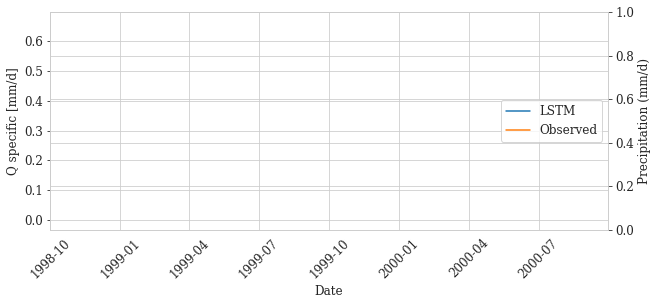

In [9]:
fig, ax = plt.subplots(figsize=(10, 4))
ax2 = ax.twinx()
#ax2.invert_yaxis()
ax.plot(Schwebich_Base['2008-10-01 00:00:00':'2009-09-30 23:00:00'])
#ax2.bar(test_data_interval.index, precip)
ax.xaxis.set_tick_params(rotation=45)
ax.set_ylabel('Q specific [mm/d]', fontsize='12')
ax.set_xlim(datetime.date(1998, 10, 1), datetime.date(2000, 9, 30))
#ax2.set_ylim(100, 0)
ax.set_xlabel('Date', fontsize='12')
ax2.set_ylabel('Precipitation (mm/d)', fontsize='12')
ax.legend(['LSTM', 'Observed'], loc=7)

Text(0.5, 0.98, 'BASE-LSTM performance spread over initial seeds')

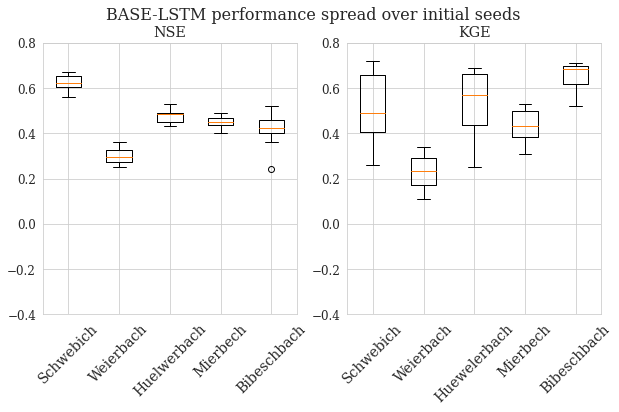

In [10]:
### Box plot performance spread over initial seeding

os.chdir('/pfs/data5/home/kit/stud/updzl/Experiment 1/')

NSE_BASE = {'Schwebich':[0.63,0.62,0.62,0.66,0.60,0.67,0.58,0.56,0.66,0.61],
            'Weierbach':[0.28,0.25,0.36,0.27,0.31,0.31,0.33,0.28,0.36,0.27],
            'Huelwerbach':[0.44,0.50,0.49,0.48,0.49,0.43,0.49,0.47,0.53,0.43],
            'Mierbech':[0.42,0.45,0.45,0.45,0.47,0.47,0.43,0.46,0.40,0.49],
            'Bibeschbach':[0.41,0.44,0.52,0.45,0.24,0.46,0.41,0.36,0.40,0.50],
           }
KGE_BASE = {'Schwebich':[0.61,0.67,0.26,0.30,0.39,0.70,0.45,0.49,0.72,0.49],
            'Weierbach':[0.11,0.25,0.16,0.32,0.27,0.21,0.30,0.14,0.22,0.34],
            'Huewelerbach':[0.25,0.69,0.43,0.56,0.69,0.40,0.46,0.58,0.60,0.68],
            'Mierbech':[0.40,0.36,0.38,0.50,0.31,0.44,0.52,0.42,0.53,0.50],
            'Bibeschbach':[0.70,0.71,0.68,0.69,0.60,0.57,0.7,0.69,0.67,0.52],
           }

fig, ax = plt.subplots(1, 2)
plt.rcParams['font.family'] = 'DeJavu Serif'
plt.rcParams['font.serif'] = ['Times New Roman']
fig.set_size_inches(10, 5)
ax[0].boxplot(NSE_BASE.values())
ax[0].set_xticklabels(NSE_BASE.keys(), rotation=45, size=14)
ax[0].set_ylim([-0.4, 0.8])
ax[0].set_title('NSE')
ax[1].boxplot(KGE_BASE.values())
ax[1].set_xticklabels(KGE_BASE.keys(), rotation=45, size=14)
ax[1].set_ylim([-0.4, 0.8])
ax[1].set_title('KGE')
fig.suptitle('BASE-LSTM performance spread over initial seeds', size=16)

Text(0.5, 0.98, 'MAX-LSTM performance spread over initial seeds')

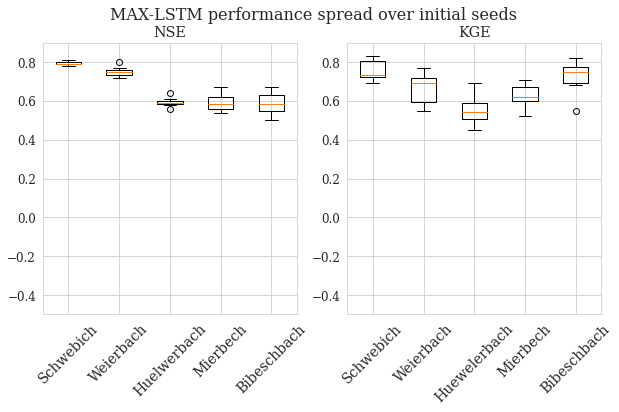

In [11]:
NSE_MAX = {'Schwebich':[0.80,0.79,0.79,0.80,0.79,0.79,0.78,0.78,0.81,0.80],
            'Weierbach':[0.76,0.73,0.72,0.80,0.73,0.75,0.76,0.75,0.75,0.77],
            'Huelwerbach':[0.56,0.59,0.58,0.58,0.60,0.59,0.61,0.59,0.59,0.64],
            'Mierbech':[0.54,0.56,0.56,0.62,0.55,0.67,0.61,0.60,0.57,0.62],
            'Bibeschbach':[0.54,0.63,0.58,0.57,0.63,0.59,0.50,0.52,0.67,0.65],
           }
KGE_MAX = {'Schwebich':[0.83,0.73,0.73,0.74,0.77,0.70,0.69,0.83,0.72,0.82],
            'Weierbach':[0.72,0.61,0.70,0.77,0.59,0.55,0.68,0.59,0.71,0.73],
            'Huewelerbach':[0.50,0.55,0.60,0.63,0.54,0.55,0.53,0.45,0.48,0.69],
            'Mierbech':[0.52,0.62,0.68,0.67,0.58,0.61,0.65,0.60,0.71],
            'Bibeschbach':[0.68,0.69,0.78,0.76,0.81,0.76,0.69,0.74,0.82,0.55],
           }

fig, ax = plt.subplots(1, 2)
plt.rcParams['font.family'] = 'DeJavu Serif'
plt.rcParams['font.serif'] = ['Times New Roman']
fig.set_size_inches(10, 5)
ax[0].boxplot(NSE_MAX.values())
ax[0].set_xticklabels(NSE_MAX.keys(), rotation=45, size=14)
ax[0].set_ylim([-0.5, 0.9])
ax[0].set_title('NSE')
ax[1].boxplot(KGE_MAX.values())
ax[1].set_xticklabels(KGE_MAX.keys(), rotation=45, size=14)
ax[1].set_ylim([-0.5, 0.9])
ax[1].set_title('KGE')
fig.suptitle('MAX-LSTM performance spread over initial seeds', size= 16)

Text(0.5, 0.98, 'SELEC-LSTM performance spread over initial seeds')

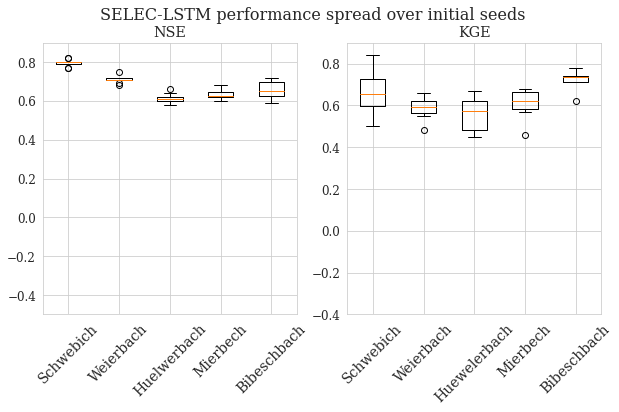

In [12]:
NSE_SELEC = {'Schwebich':[0.79,0.79,0.77,0.80,0.77,0.82,0.80,0.82,0.80],
            'Weierbach':[0.72,0.75,0.72,0.71,0.71,0.71,0.69,0.71,0.72,0.68],
            'Huelwerbach':[0.61,0.60,0.61,0.64,0.58,0.59,0.61,0.62,0.66,0.60],
            'Mierbech':[0.60,0.65,0.62,0.63,0.68,0.62,0.61,0.66,0.64,0.62],
            'Bibeschbach':[0.59,0.72,0.65,0.70,0.65,0.62,0.68,0.62,0.72,0.65],
           }
KGE_SELEC = {'Schwebich':[0.68,0.58,0.74,0.65,0.50,0.54,0.84,0.74,0.66,0.64],
            'Weierbach':[0.62,0.59,0.55,0.48,0.56,0.64,0.58,0.59,0.62,0.66],
            'Huewelerbach':[0.47,0.54,0.61,0.67,0.45,0.46,0.62,0.62,0.63,0.51],
            'Mierbech':[0.61,0.67,0.59,0.64,0.46,0.57,0.58,0.67,0.68,0.63],
            'Bibeschbach':[0.78,0.74,0.62,0.74,0.76,0.72,0.71,0.71,0.74,0.73],
           }

fig, ax = plt.subplots(1, 2)
plt.rcParams['font.family'] = 'DeJavu Serif'
plt.rcParams['font.serif'] = ['Times New Roman']
fig.set_size_inches(10, 5)
ax[0].boxplot(NSE_SELEC.values())
ax[0].set_xticklabels(NSE_SELEC.keys(), rotation=45, size=14)
ax[0].set_ylim([-0.5, 0.9])
ax[0].set_title('NSE')
ax[1].boxplot(KGE_SELEC.values())
ax[1].set_xticklabels(KGE_SELEC.keys(), rotation=45, size=14)
ax[1].set_ylim([-0.4, 0.9])
ax[1].set_title('KGE')
fig.suptitle('SELEC-LSTM performance spread over initial seeds', size= 16)

Text(0.5, 1.0, 'Bibeschbach')

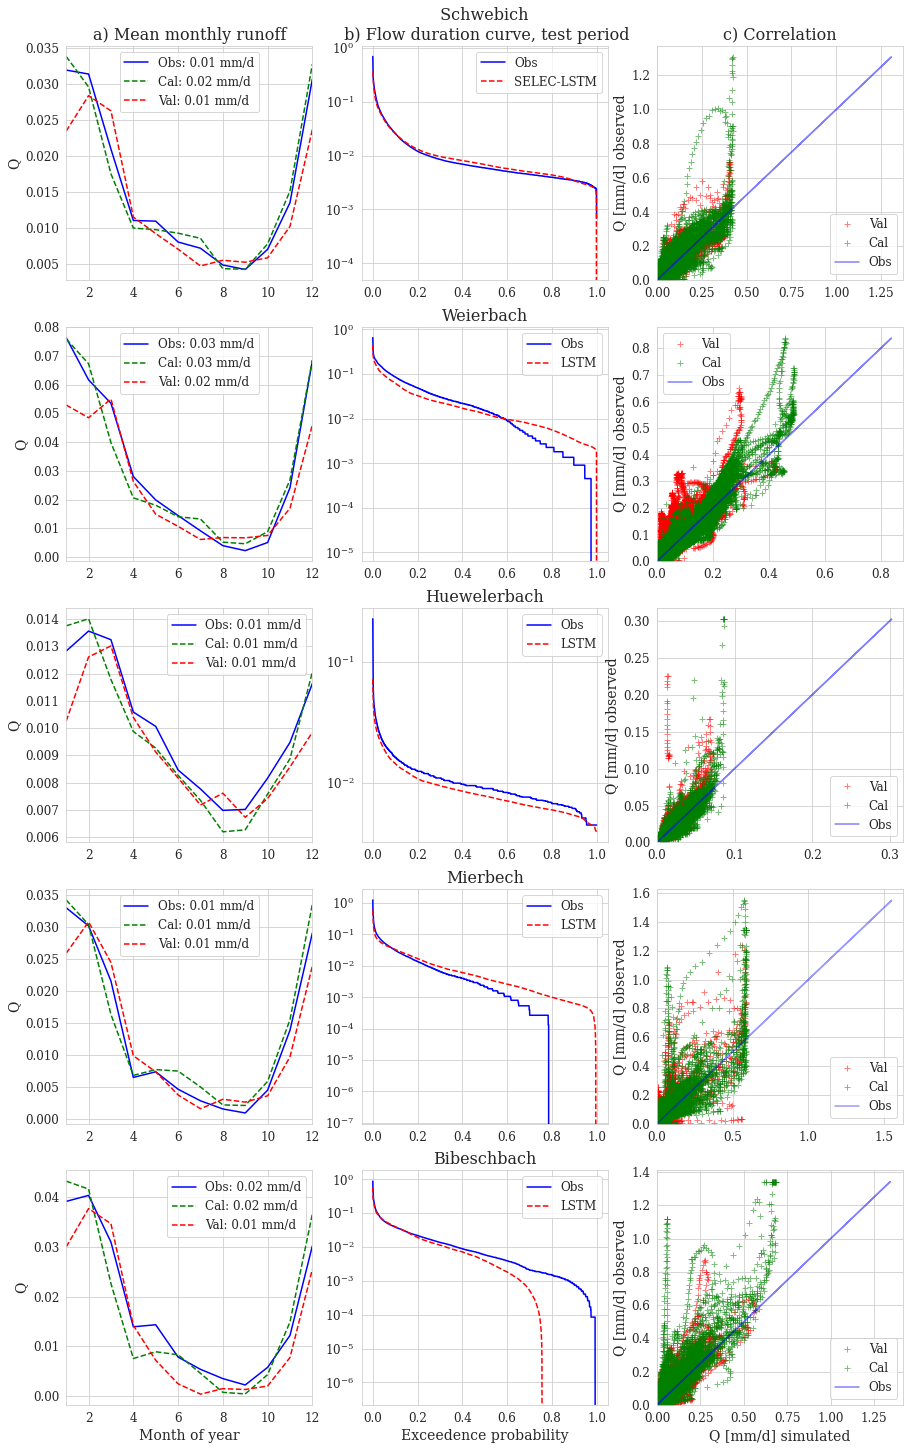

In [13]:
##### mean monthly runoff https://doi.org/10.1080/02626667.2019.1657233

#Schwebich

test_data=Schwebich_Selec
train_data=Schwebich_Selec_train

mean_val = test_data.groupby(test_data.index.month).mean()
m_v = test_data['Q_sim'].mean()
mean_cal = train_data.groupby(train_data.index.month).mean()
m_c = train_data['Q_train'].mean()
mean_obs = (mean_val+mean_cal)/2
m_o = (test_data['Q_obs'].mean()+train_data['Q_train'].mean())/2

fig1, ax1 = plt.subplots(5, 3,)# figsize=(16, 50))
plt.rcParams['font.family'] = 'DeJavu Serif'
plt.rcParams['font.serif'] = ['Times New Roman']
fig1.set_figheight(25)
fig1.set_figwidth(15)
ax1[0,0].plot(mean_obs.index, mean_obs['Q_obs'], 'b', label='Obs: '+str(round(m_o, 2))+' mm/d')
ax1[0,0].plot(mean_cal.index, mean_cal['Q_train'], 'g--', label='Cal: '+str(round(m_c, 2))+' mm/d')
ax1[0,0].plot(mean_val.index, mean_val['Q_sim'], 'r--',  label='Val: '+str(round(m_v, 2))+' mm/d')
ax1[0,0].legend();
ax1[0,0].set_ylabel('Q', fontsize='14')
#ax1[0,0].set_xlabel('Month of year', fontsize='14')
ax1[0,0].set_title('a) Mean monthly runoff', size='16')
ax1[0,0].set_xlim(1, 12)
#plt.plot(mean_obs.index, mean_obs['Q_spec(mm)'], 'b', mean_cal.index, mean_cal['predictions'], 'g--', mean_val.index, mean_val['predictions'], 'r--')

### comparing obs and sim

ax1[0,2].plot(test_data['Q_sim'], test_data['Q_obs'], 'r+', label='Val', alpha=0.5)
ax1[0,2].plot(train_data['Q_train'], train_data['Q_obs'], 'g+', label='Cal' , alpha=0.5)
ax1[0,2].plot(train_data['Q_obs'], train_data['Q_obs'],  'b-', label='Obs', alpha=0.5)
ax1[0,2].legend()
ax1[0,2].set_ylabel('Q [mm/d] observed', fontsize='14')
#ax1[0,2].set_xlabel('Q [mm/d] simulated', fontsize='14')
ax1[0,2].set_title('c) Correlation', size='16')
ax1[0,2].set_xlim(left=0)
ax1[0,2].set_ylim(bottom=0)
### flow duration curves

# train
test_pred_sort = np.sort(test_data['Q_sim'])
test_obs_sort = np.sort(test_data['Q_obs'])

p_pred= (1-1. * np.arange(len(test_pred_sort)) / (len(test_pred_sort) - 1))
p_obs= (1-1. * np.arange(len(test_obs_sort)) / (len(test_obs_sort) - 1))
ax1[0,1].plot(p_obs , test_obs_sort, 'b-', label='Obs')
ax1[0,1].plot(p_pred,test_pred_sort,'r--', label='SELEC-LSTM')
ax1[0,1].set_yscale('log')
#ax1[1].set_ylabel('Q specific [mm/d]', fontsize='13')
#ax1[0,1].set_xlabel('Exceedence probability', fontsize='14')
ax1[0,1].set_title(' Schwebich \n b) Flow duration curve, test period', size='16')
#ax1[0,1].set_ylim(min(test_pred_sort) , max(test_obs_sort))
#ax1[0,1].set_xlim(0, 1)
ax1[0,1].legend()

test_data=Weierbach_Selec
train_data=Weierbach_Selec_train

mean_val = test_data.groupby(test_data.index.month).mean()
m_v = test_data['Q_sim'].mean()
mean_cal = train_data.groupby(train_data.index.month).mean()
m_c = train_data['Q_train'].mean()
mean_obs = (mean_val+mean_cal)/2
m_o = (test_data['Q_obs'].mean()+train_data['Q_train'].mean())/2

ax1[1,0].plot(mean_obs.index, mean_obs['Q_obs'], 'b', label='Obs: '+str(round(m_o, 2))+' mm/d')
ax1[1,0].plot(mean_cal.index, mean_cal['Q_train'], 'g--', label='Cal: '+str(round(m_c, 2))+' mm/d')
ax1[1,0].plot(mean_val.index, mean_val['Q_sim'], 'r--',  label='Val: '+str(round(m_v, 2))+' mm/d')
ax1[1,0].legend();
ax1[1,0].set_ylabel('Q', fontsize='14')
#ax1[1,0].set_xlabel('Month of year', fontsize='14')
#ax1[1,0].set_title('Mean monthly runoff', size='16')
ax1[1,0].set_xlim(1, 12)
#plt.plot(mean_obs.index, mean_obs['Q_spec(mm)'], 'b', mean_cal.index, mean_cal['predictions'], 'g--', mean_val.index, mean_val['predictions'], 'r--')

### comparing obs and sim

ax1[1,2].plot(test_data['Q_sim'], test_data['Q_obs'], 'r+', label='Val', alpha=0.5)
ax1[1,2].plot(train_data['Q_train'], train_data['Q_obs'], 'g+', label='Cal' , alpha=0.5)
ax1[1,2].plot(train_data['Q_obs'], train_data['Q_obs'],  'b-', label='Obs', alpha=0.5)
ax1[1,2].legend()
ax1[1,2].set_ylabel('Q [mm/d] observed', fontsize='14')
#ax1[1,2].set_xlabel('Q [mm/d] simulated', fontsize='14')
#ax1[1,2].set_title('Correlation', size='16')
ax1[1,2].set_xlim(left=0)
ax1[1,2].set_ylim(bottom=0)
### flow duration curves

# train
test_pred_sort = np.sort(test_data['Q_sim'])
test_obs_sort = np.sort(test_data['Q_obs'])

p_pred= (1-1. * np.arange(len(test_pred_sort)) / (len(test_pred_sort) - 1))
p_obs= (1-1. * np.arange(len(test_obs_sort)) / (len(test_obs_sort) - 1))
ax1[1,1].plot(p_obs , test_obs_sort, 'b-', label='Obs')
ax1[1,1].plot(p_pred,test_pred_sort,'r--', label='LSTM')
ax1[1,1].set_yscale('log')
#ax1[1].set_ylabel('Q specific [mm/d]', fontsize='13')
#ax1[1,1].set_xlabel('Exceedence probability', fontsize='14')
#ax1[1,1].set_title('Flow duration curve, test period', size='16')
#ax1[0,1].set_ylim(min(test_pred_sort) , max(test_obs_sort))
#ax1[0,1].set_xlim(0, 1)
ax1[1,1].legend()

test_data=Huewelerbach_Selec
train_data=Huewelerbach_Selec_train

mean_val = test_data.groupby(test_data.index.month).mean()
m_v = test_data['Q_sim'].mean()
mean_cal = train_data.groupby(train_data.index.month).mean()
m_c = train_data['Q_train'].mean()
mean_obs = (mean_val+mean_cal)/2
m_o = (test_data['Q_obs'].mean()+train_data['Q_train'].mean())/2

ax1[2,0].plot(mean_obs.index, mean_obs['Q_obs'], 'b', label='Obs: '+str(round(m_o, 2))+' mm/d')
ax1[2,0].plot(mean_cal.index, mean_cal['Q_train'], 'g--', label='Cal: '+str(round(m_c, 2))+' mm/d')
ax1[2,0].plot(mean_val.index, mean_val['Q_sim'], 'r--',  label='Val: '+str(round(m_v, 2))+' mm/d')
ax1[2,0].legend();
ax1[2,0].set_ylabel('Q', fontsize='14')
#ax1[2,0].set_xlabel('Month of year', fontsize='14')
#ax1[1,0].set_title('Mean monthly runoff', size='16')
ax1[2,0].set_xlim(1, 12)
#plt.plot(mean_obs.index, mean_obs['Q_spec(mm)'], 'b', mean_cal.index, mean_cal['predictions'], 'g--', mean_val.index, mean_val['predictions'], 'r--')

### comparing obs and sim

ax1[2,2].plot(test_data['Q_sim'], test_data['Q_obs'], 'r+', label='Val', alpha=0.5)
ax1[2,2].plot(train_data['Q_train'], train_data['Q_obs'], 'g+', label='Cal', alpha=0.5 )
ax1[2,2].plot(train_data['Q_obs'], train_data['Q_obs'],  'b-', label='Obs', alpha=0.5)
ax1[2,2].legend()
ax1[2,2].set_ylabel('Q [mm/d] observed', fontsize='14')
#ax1[2,2].set_xlabel('Q [mm/d] simulated', fontsize='14')
#ax1[1,2].set_title('Correlation', size='16')
ax1[2,2].set_xlim(left=0)
ax1[2,2].set_ylim(bottom=0)
### flow duration curves

# train
test_pred_sort = np.sort(test_data['Q_sim'])
test_obs_sort = np.sort(test_data['Q_obs'])

p_pred= (1-1. * np.arange(len(test_pred_sort)) / (len(test_pred_sort) - 1))
p_obs= (1-1. * np.arange(len(test_obs_sort)) / (len(test_obs_sort) - 1))
ax1[2,1].plot(p_obs , test_obs_sort, 'b-', label='Obs')
ax1[2,1].plot(p_pred,test_pred_sort,'r--', label='LSTM')
ax1[2,1].set_yscale('log')
#ax1[1].set_ylabel('Q specific [mm/d]', fontsize='13')
#ax1[2,1].set_xlabel('Exceedence probability', fontsize='14')
#ax1[1,1].set_title('Flow duration curve, test period', size='16')
#ax1[0,1].set_ylim(min(test_pred_sort) , max(test_obs_sort))
#ax1[0,1].set_xlim(0, 1)
ax1[2,1].legend()

test_data=Mierbech_Selec
train_data=Mierbech_Selec_train

mean_val = test_data.groupby(test_data.index.month).mean()
m_v = test_data['Q_sim'].mean()
mean_cal = train_data.groupby(train_data.index.month).mean()
m_c = train_data['Q_train'].mean()
mean_obs = (mean_val+mean_cal)/2
m_o = (test_data['Q_obs'].mean()+train_data['Q_train'].mean())/2

ax1[3,0].plot(mean_obs.index, mean_obs['Q_obs'], 'b', label='Obs: '+str(round(m_o, 2))+' mm/d')
ax1[3,0].plot(mean_cal.index, mean_cal['Q_train'], 'g--', label='Cal: '+str(round(m_c, 2))+' mm/d')
ax1[3,0].plot(mean_val.index, mean_val['Q_sim'], 'r--',  label='Val: '+str(round(m_v, 2))+' mm/d')
ax1[3,0].legend();
ax1[3,0].set_ylabel('Q', fontsize='14')
#ax1[3,0].set_xlabel('Month of year', fontsize='14')
#ax1[1,0].set_title('Mean monthly runoff', size='16')
ax1[3,0].set_xlim(1, 12)
#plt.plot(mean_obs.index, mean_obs['Q_spec(mm)'], 'b', mean_cal.index, mean_cal['predictions'], 'g--', mean_val.index, mean_val['predictions'], 'r--')

### comparing obs and sim

ax1[3,2].plot(test_data['Q_sim'], test_data['Q_obs'], 'r+', label='Val', alpha=0.5)
ax1[3,2].plot(train_data['Q_train'], train_data['Q_obs'], 'g+', label='Cal', alpha=0.5 )
ax1[3,2].plot(train_data['Q_obs'], train_data['Q_obs'],  'b-', label='Obs', alpha=0.4)
ax1[3,2].legend()
ax1[3,2].set_ylabel('Q [mm/d] observed', fontsize='14')
#ax1[3,2].set_xlabel('Q [mm/d] simulated', fontsize='14')
#ax1[1,2].set_title('Correlation', size='16')
ax1[3,2].set_xlim(left=0)
ax1[3,2].set_ylim(bottom=0)
### flow duration curves

# train
test_pred_sort = np.sort(test_data['Q_sim'])
test_obs_sort = np.sort(test_data['Q_obs'])

p_pred= (1-1. * np.arange(len(test_pred_sort)) / (len(test_pred_sort) - 1))
p_obs= (1-1. * np.arange(len(test_obs_sort)) / (len(test_obs_sort) - 1))
ax1[3,1].plot(p_obs , test_obs_sort, 'b-', label='Obs')
ax1[3,1].plot(p_pred,test_pred_sort,'r--', label='LSTM')
ax1[3,1].set_yscale('log')
#ax1[1].set_ylabel('Q specific [mm/d]', fontsize='13')
#ax1[3,1].set_xlabel('Exceedence probability', fontsize='14')
#ax1[1,1].set_title('Flow duration curve, test period', size='16')
#ax1[0,1].set_ylim(min(test_pred_sort) , max(test_obs_sort))
#ax1[0,1].set_xlim(0, 1)
ax1[3,1].legend()

test_data=Bibeschbach_Selec
train_data=Bibeschbach_Selec_train

mean_val = test_data.groupby(test_data.index.month).mean()
m_v = test_data['Q_sim'].mean()
mean_cal = train_data.groupby(train_data.index.month).mean()
m_c = train_data['Q_train'].mean()
mean_obs = (mean_val+mean_cal)/2
m_o = (test_data['Q_obs'].mean()+train_data['Q_train'].mean())/2

ax1[4,0].plot(mean_obs.index, mean_obs['Q_obs'], 'b', label='Obs: '+str(round(m_o, 2))+' mm/d')
ax1[4,0].plot(mean_cal.index, mean_cal['Q_train'], 'g--', label='Cal: '+str(round(m_c, 2))+' mm/d')
ax1[4,0].plot(mean_val.index, mean_val['Q_sim'], 'r--',  label='Val: '+str(round(m_v, 2))+' mm/d')
ax1[4,0].legend();
ax1[4,0].set_ylabel('Q', fontsize='14')
ax1[4,0].set_xlabel('Month of year', fontsize='14')
#ax1[1,0].set_title('Mean monthly runoff', size='16')
ax1[4,0].set_xlim(1, 12)
#plt.plot(mean_obs.index, mean_obs['Q_spec(mm)'], 'b', mean_cal.index, mean_cal['predictions'], 'g--', mean_val.index, mean_val['predictions'], 'r--')

### comparing obs and sim

ax1[4,2].plot(test_data['Q_sim'], test_data['Q_obs'], 'r+', label='Val', alpha=0.5)
ax1[4,2].plot(train_data['Q_train'], train_data['Q_obs'], 'g+', label='Cal' , alpha=0.5)
ax1[4,2].plot(train_data['Q_obs'], train_data['Q_obs'],  'b-', label='Obs', alpha=0.5)
ax1[4,2].legend()
ax1[4,2].set_ylabel('Q [mm/d] observed', fontsize='14')
ax1[4,2].set_xlabel('Q [mm/d] simulated', fontsize='14')
#ax1[1,2].set_title('Correlation', size='16')
ax1[4,2].set_xlim(left=0)
ax1[4,2].set_ylim(bottom=0)
### flow duration curves

# train
test_pred_sort = np.sort(test_data['Q_sim'])
test_obs_sort = np.sort(test_data['Q_obs'])

p_pred= (1-1. * np.arange(len(test_pred_sort)) / (len(test_pred_sort) - 1))
p_obs= (1-1. * np.arange(len(test_obs_sort)) / (len(test_obs_sort) - 1))
ax1[4,1].plot(p_obs , test_obs_sort, 'b-', label='Obs')
ax1[4,1].plot(p_pred,test_pred_sort,'r--', label='LSTM')
ax1[4,1].set_yscale('log')
#ax1[1].set_ylabel('Q specific [mm/d]', fontsize='13')
ax1[4,1].set_xlabel('Exceedence probability', fontsize='14')
#ax1[1,1].set_title('Flow duration curve, test period', size='16')
#ax1[0,1].set_ylim(min(test_pred_sort) , max(test_obs_sort))
#ax1[0,1].set_xlim(0, 1)
ax1[4,1].legend()

#fig1.suptitle('Schwebich', fontsize=16)
ax1[1,1].set_title('Weierbach', size='16')
ax1[2,1].set_title('Huewelerbach', size='16')
ax1[3,1].set_title('Mierbech', size='16')
ax1[4,1].set_title('Bibeschbach', size='16')                   

In [17]:
column = Schwebich_Selec['Q_obs']
count = column[column > max(Schwebich_Selec['Q_sim'])].count()
count

count/len(Schwebich_Selec['Q_obs'])

0.0008030823063758999

In [29]:
cl = Mierbech_Selec
count = (cl['Q_obs'] > max(cl['Q_sim'])).sum()
print(count)

90
